### Importing libraries and Data

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

games_filepath = '/content/drive/MyDrive/IS 451 Group Project/Data/Spreadspoke/spreadspoke_scores.csv'
teams_filepath = '/content/drive/MyDrive/IS 451 Group Project/Data/Spreadspoke/nfl_teams.csv'
stadiums_filepath = '/content/drive/MyDrive/IS 451 Group Project/Data/Spreadspoke/stadiums.csv'

games = pd.read_csv(games_filepath)
teams = pd.read_csv(teams_filepath)
stadiums = pd.read_csv(stadiums_filepath)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

---


In [ ]:
df = pd.merge(games,stadiums[['stadium_capacity','stadium_name','stadium_type','stadium_latitude','stadium_longitude','stadium_azimuthangle','stadium_elevation']], left_on = 'stadium', right_on = 'stadium_name', how = 'left')

# Drop unnecessary columns from 'teams'
teams.drop(columns=['Conference', 'Division', 'ID'], inplace=True)

# Map team names to abbreviations for 'team_home'
df = pd.merge(df, teams, left_on='team_home', right_on='Name', how='left')
df.rename(columns={'Abbreviation': 'team_home_abbrev'}, inplace=True)
df.drop('Name', axis=1, inplace=True)

# Map team names to abbreviations for 'team_away'
df = pd.merge(df, teams, left_on='team_away', right_on='Name', how='left')
df.rename(columns={'Abbreviation': 'team_away_abbrev'}, inplace=True)
df.drop('Name', axis=1, inplace=True)

# Drop original team name columns ('team_home' and 'team_away')
df.drop(columns=['team_home', 'team_away'], inplace=True)

# Rename abbreviation columns to 'team_home' and 'team_away'
df.rename(columns={'team_home_abbrev': 'team_home', 'team_away_abbrev': 'team_away'}, inplace=True)

# Clean 'schedule_date' column
df['stadium_capacity'] = df['stadium_capacity'].str.replace(',', '').astype(float)

#set default value in weather_detail to prevent NANs
df['weather_detail'].fillna('normal', inplace=True)

# Clean 'week' column
df['schedule_week'].replace({'Division': 19, 'Wildcard': 20, 'Conference': 21, 'Superbowl': 22}, inplace=True)
df['schedule_week'] = df['schedule_week'].astype(int)

# need to make spread column relative to home team (not relative to favorite team)
def adjust_point_spread(row):
  if row['team_home'] != row['team_favorite_id']:
    return row['spread_favorite']
  else:
    return -row['spread_favorite']
df['spread_favorite'] = df.apply(adjust_point_spread, axis=1)

###TIME SERIES###
#clean date and sort rows by date
from datetime import datetime

df['schedule_date']= pd.to_datetime(df['schedule_date'])
df.sort_values('schedule_date', inplace=True)

# Filter and keep rows where 'schedule_date' is earlier or equal to today's date
today_date = datetime.today()
data = df[df['schedule_date'] <= today_date]

# add month column
df['month'] = df['schedule_date'].dt.month

### Feature Engineering


---





In [ ]:
#add prediction variable home_win
df['score_diff'] = df['score_home'] - df['score_away']
def home_win(difference):
  if difference < 0:
    return False
  else:
    return True
df['home_win'] = df['score_diff'].apply(home_win)

window_size = 1

# Calculate cumulative wins for home team
df['team_home_rolling_wins'] = df.groupby(['team_home', 'schedule_season'])['home_win'].cumsum() - df['home_win']

# Calculate cumulative wins for away team
df['team_away_rolling_wins'] = df.groupby(['team_away', 'schedule_season'])['home_win'].apply(lambda x: x[::-1].cumsum()[::-1]) - df['home_win']

# Replace NaN values (resulting from the first game of each team) with 0
df['team_home_rolling_wins'].fillna(0, inplace=True)
df['team_away_rolling_wins'].fillna(0, inplace=True)

#drop teams that no longer exist, since they had no abbreviation value in the key dictionary
df.dropna(subset=['team_home', 'team_away'], how='any', inplace=True)

#Calculate total_score, over_under_line, over_line_actual
df['total_score'] = df['score_home'] + df['score_away']
df['over_under_line'] = pd.to_numeric(df['over_under_line'], errors='coerce')
df['over_line_actual'] = df['total_score'] > df['over_under_line']


# Create dummy variables
# Get dummies for categorical columns
categorical_columns = ['team_home','team_away','weather_detail','stadium_type']
dummies = pd.get_dummies(df[categorical_columns], prefix=categorical_columns)

# Concatenate the dummies with the original DataFrame
df = pd.concat([df, dummies], axis=1)

# Drop the original categorical columns if needed
df.drop(categorical_columns, axis=1, inplace=True)


<ipython-input-7-9fe6de9cedce>:16: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['team_away_rolling_wins'] = df.groupby(['team_away', 'schedule_season'])['home_win'].apply(lambda x: x[::-1].cumsum()[::-1]) - df['home_win']


### Data Quality Check

---



In [ ]:
# Calculate the percentage of NaN values in each column
nan_columns = df.columns[df.isnull().any()]
nan_percentage = df[nan_columns].isnull().mean() * 100

print("Percentage of NaN values in columns:")
print(nan_percentage)

Percentage of NaN values in columns:
score_home               1.367796
score_away               1.367796
team_favorite_id        15.619028
spread_favorite         15.619028
over_under_line         16.071608
weather_temperature     11.294378
weather_wind_mph        11.425123
weather_humidity        42.150256
stadium_capacity        42.160314
stadium_latitude        13.748366
stadium_longitude       13.748366
stadium_azimuthangle    33.903249
stadium_elevation       24.127527
score_diff               1.367796
total_score              1.367796
dtype: float64


In [ ]:
#Display percentage of NANs by column by year
pd.set_option('display.max_columns', None)
print(df.groupby('schedule_season').apply(lambda x: x.isnull().mean() * 100))
pd.reset_option('display.max_columns')

                 schedule_date  schedule_season  schedule_week  \
schedule_season                                                  
1966                       0.0              0.0            0.0   
1967                       0.0              0.0            0.0   
1968                       0.0              0.0            0.0   
1969                       0.0              0.0            0.0   
1970                       0.0              0.0            0.0   
1971                       0.0              0.0            0.0   
1972                       0.0              0.0            0.0   
1973                       0.0              0.0            0.0   
1974                       0.0              0.0            0.0   
1975                       0.0              0.0            0.0   
1976                       0.0              0.0            0.0   
1977                       0.0              0.0            0.0   
1978                       0.0              0.0            0.0   
1979      

In [ ]:
#interpolate missing values
columns_to_interpolate = ['weather_humidity', 'stadium_elevation', 'stadium_azimuthangle']
df[columns_to_interpolate] = df[columns_to_interpolate].interpolate(method='linear')

In [ ]:
# Calculate the percentage of NaN values in each column
nan_columns = df.columns[df.isnull().any()]
nan_percentage = df[nan_columns].isnull().mean() * 100

print("Percentage of NaN values in columns:")
print(nan_percentage)

Percentage of NaN values in columns:
score_home               1.367796
score_away               1.367796
team_favorite_id        15.619028
spread_favorite         15.619028
over_under_line         16.071608
weather_temperature     11.294378
weather_wind_mph        11.425123
stadium_capacity        42.160314
stadium_latitude        13.748366
stadium_longitude       13.748366
stadium_azimuthangle     0.060344
score_diff               1.367796
total_score              1.367796
dtype: float64


### Prediction Function

---



In [ ]:
def predict(dataframe, season_choice, model_choice, drop_features, target_variable):
  import pandas as pd
  from sklearn.ensemble import RandomForestClassifier
  # evaluate a model to predict game winner based on features
  # Split the data into training and testing based on the schedule_date

  dataframe.dropna(axis = 0, inplace = True)

  train_data = dataframe[dataframe['schedule_season'] < season_choice]
  test_data = dataframe[dataframe['schedule_season'] == season_choice]


  # Feature selection
  X_train = train_data.drop(drop_features, axis=1) # drop target variable and others
  y_train = train_data[target_variable]
  X_test = test_data.drop(drop_features, axis=1) # drop target variable and others
  y_test = test_data[target_variable]

  # creating the model
  model = model_choice.fit(X_train, y_train)
  X_train['y_pred'] = model.predict(X_train)
  X_test['y_pred'] = model.predict(X_test)

  # merge evaluation metrics back into train and test
  eval_train = pd.merge(X_train, train_data[['total_score','over_under_line', 'over_line_actual','home_win']], left_index=True, right_index=True, how='left')
  eval_test = pd.merge(X_test, test_data[['total_score','over_under_line', 'over_line_actual','home_win']], left_index=True, right_index=True, how='left')

  #calculate accuracy metrics
  from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

  rows_train = eval_train.shape[0]
  rows_test = eval_test.shape[0]

  #more home wins, index 0
  base_accuracy_train = eval_train[target].value_counts()[0] / eval_train[target].shape[0]
  cm_train = confusion_matrix(eval_train[target], eval_train['y_pred'])
  accuracy_train = accuracy_score(eval_train[target], eval_train['y_pred'])
  precision_train = precision_score(eval_train[target], eval_train['y_pred'])
  recall_train = recall_score(eval_train[target], eval_train['y_pred'])

  base_accuracy_test = eval_test[target].value_counts()[0] / eval_test[target].shape[0]
  cm_test = confusion_matrix(eval_test[target], eval_test['y_pred'])
  accuracy_test = accuracy_score(eval_test[target], eval_test['y_pred'])
  precision_test = precision_score(eval_test[target], eval_test['y_pred'])
  recall_test = recall_score(eval_test[target], eval_test['y_pred'])

  def calc_profit(row):
    if row[target] == row['y_pred']:
      profit = 90
    else:
      profit = -100
    return profit

  baseline_profit_test = (eval_test[target].value_counts()[0] * 90) + (eval_test[target].value_counts()[1] * -100)
  baseline_profit_train = (eval_train[target].value_counts()[0] * 90) + (eval_train[target].value_counts()[1] * -100)
  eval_test['profit'] = eval_test.apply(calc_profit, axis=1)
  eval_train['profit'] = eval_train.apply(calc_profit, axis=1)

  train_profit = eval_train['profit'].sum()
  test_profit = eval_test['profit'].sum()

  season_metrics = [season_choice,rows_train,rows_test,cm_train,cm_test,base_accuracy_train,base_accuracy_test,accuracy_train,accuracy_test,baseline_profit_train,baseline_profit_test,train_profit,test_profit]
  return season_metrics

###Backtest Prediction Accuracy Function


---



In [ ]:
def backtest(data,model,drop_features,target,start_season= 1980,step=1):
  all_seasons = {}

  for i in range(start_season,2023,step):
    if data[data['schedule_season']==i].shape[0] != 0:
      season = predict(data,i,model,drop_features,target)
      all_seasons.update({i: season})

  as_df = pd.DataFrame(all_seasons)
  as_df = as_df.transpose()
  as_df.columns = ['season_choice','rows_train','rows_test','cm_train','cm_test','base_accuracy_train','base_accuracy_test','accuracy_train','accuracy_test','baseline_profit_train','baseline_profit_test','train_profit','test_profit']

  #calculate cumulatives
  as_df['base_profit_cum'] = as_df['baseline_profit_test'].cumsum()
  as_df['model_profit_cum'] = as_df['test_profit'].cumsum()

  return as_df

### Visualize Prediction Results Function


---



In [ ]:
def plot_strategy_comparison(data,strategy_1,strategy_2,title):
  import matplotlib.pyplot as plt
  years = data.index.values
  strat_1 = data[strategy_1]
  strat_2 = data[strategy_2]

  bar_width = 0.35
  x = np.arange(len(years))  # Create an array of the same length as years

  # Plotting
  plt.figure(figsize=(12, 6))
  plt.bar(x - bar_width/2, strat_1, label=strategy_1, width=bar_width, alpha=0.7)
  plt.bar(x + bar_width/2, strat_2, label=strategy_2, width=bar_width, alpha=0.7)
  plt.xlabel('Season')
  plt.ylabel(strategy_1 + '/' + strategy_2)
  plt.title(title)
  plt.legend()
  plt.xticks(range(len(years)), years)
  plt.xticks(rotation=45)
  plt.tight_layout()

  # Show plot
  plt.show()

### Make Predictions!!

---



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#define arguments

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf = 20, class_weight = {0:1,1:1}, random_state = 42)
logreg = LogisticRegression(max_iter=1000)
not_features = ['spread_favorite','team_favorite_id','schedule_date', 'schedule_playoff', 'score_home', 'score_away', 'stadium', 'stadium_name', 'stadium_neutral', 'total_score', 'over_line_actual','home_win','score_diff']
target = 'home_win'
baseline = 'baseline_profit_test'
strategic = 'test_profit'
baseline_cum = 'base_profit_cum'
strategic_cum = 'model_profit_cum'
include_columns = df.drop(columns = not_features).columns

In [ ]:
###Predict With Logistic Regression
backtest_seasons_logit = backtest(df,logreg,not_features,target,1990)

In [ ]:
###Predict With Random Forests
backtest_seasons_rf = backtest(df,rf,not_features,target,1990)

In [ ]:
backtest_seasons_rf

season_choice rows_train rows_test                    cm_train  \
1990          1990        267        27        [[4, 103], [0, 160]]   
1991          1991        294        29        [[5, 109], [0, 180]]   
1992          1992        323        36        [[9, 115], [3, 196]]   
1993          1993        359        33        [[5, 131], [2, 221]]   
1994          1994        392        43        [[4, 143], [1, 244]]   
1995          1995        435        46        [[3, 160], [0, 272]]   
1996          1996        481        51        [[2, 176], [0, 303]]   
1997          1997        532        52        [[2, 188], [0, 342]]   
1998          1998        584        65        [[0, 211], [0, 373]]   
1999          1999        649        87        [[0, 231], [0, 418]]   
2000          2000        736        93        [[0, 263], [0, 473]]   
2001          2001        829       109        [[3, 303], [0, 523]]   
2002          2002        938       125       [[20, 339], [5, 574]]   
2003          2003       1063       136      [[57, 359], [16, 631]]   
2004          2004       1199       137      [[64, 402], [16, 717]]   
2005          2005       1336       146      [[75, 448], [24, 789]]   
2006          2006       1482       142      [[92, 489], [32, 869]]   
2007          2007       1624       141     [[127, 522], [55, 920]]   
2008          2008       1765       149    [[149, 554], [52, 1010]]   
2009          2009       1914       154    [[133, 633], [49, 1099]]   
2010          2010       2068       171    [[138, 690], [48, 1192]]   
2011          2011       2239       167    [[175, 726], [59, 1279]]   
2012          2012       2406       170    [[196, 775], [67, 1368]]   
2013          2013       2576       166    [[233, 811], [84, 1448]]   
2014          2014       2742       184    [[260, 851], [88, 1543]]   
2015          2015       2926       180    [[301, 885], [99, 1641]]   
2016          2016       3106       203   [[355, 916], [119, 1716]]   
2017          2017       3309       232   [[380, 973], [116, 1840]]   
2018          2018       3541       233  [[427, 1028], [132, 1954]]   
2019          2019       3774        67  [[437, 1109], [143, 2085]]   
2020          2020       3841        98  [[457, 1121], [150, 2113]]   
2021          2021       3939       133  [[491, 1140], [162, 2146]]   
2022          2022       4072        98  [[516, 1180], [176, 2200]]   

                    cm_test base_accuracy_train base_accuracy_test  \
1990      [[0, 7], [0, 20]]            0.599251           0.740741   
1991     [[0, 10], [0, 19]]            0.612245           0.655172   
1992     [[0, 12], [0, 24]]            0.616099           0.666667   
1993     [[0, 11], [0, 22]]             0.62117           0.666667   
1994     [[0, 16], [0, 27]]               0.625           0.627907   
1995     [[0, 15], [0, 31]]            0.625287           0.673913   
1996     [[0, 12], [0, 39]]            0.629938           0.764706   
1997     [[0, 21], [0, 31]]            0.642857           0.596154   
1998     [[0, 20], [0, 45]]            0.638699           0.692308   
1999     [[0, 32], [0, 55]]            0.644068           0.632184   
2000     [[0, 43], [0, 50]]            0.642663           0.537634   
2001     [[1, 52], [0, 56]]            0.630881           0.513761   
2002     [[0, 57], [3, 65]]            0.617271              0.544   
2003     [[8, 42], [6, 80]]            0.608655           0.632353   
2004     [[5, 52], [6, 74]]            0.611343           0.583942   
2005    [[8, 50], [10, 78]]            0.608533            0.60274   
2006   [[16, 52], [11, 63]]            0.607962           0.521127   
2007   [[10, 44], [22, 65]]            0.600369           0.617021   
2008   [[18, 45], [13, 73]]              0.6017           0.577181   
2009    [[10, 52], [3, 89]]            0.599791           0.597403   
2010    [[10, 63], [5, 93]]            0.599613           0.573099   
2011    [[10, 60], [9, 88]]            0.597588   

In [ ]:
df.groupby('schedule_season')['team_home_rolling_wins'].value_counts()

schedule_season  team_home_rolling_wins
1979             2.0                       11
                 1.0                        5
                 0.0                        4
                 3.0                        4
                 4.0                        3
                                           ..
2022             9.0                        2
2023             0.0                       21
                 1.0                       11
                 2.0                        4
                 3.0                        2
Name: team_home_rolling_wins, Length: 348, dtype: int64

In [ ]:
df[df['schedule_season']==2015]['team_home_rolling_wins']

11343    0.0
11351    0.0
11350    0.0
11348    0.0
11355    0.0
        ... 
11605    8.0
11606    6.0
11607    9.0
11608    7.0
11609    8.0
Name: team_home_rolling_wins, Length: 180, dtype: float64

In [ ]:
backtest_seasons_rf[['season_choice','rows_train','rows_test']]

season_choice rows_train rows_test
1990          1990        267        27
1991          1991        294        29
1992          1992        323        36
1993          1993        359        33
1994          1994        392        43
1995          1995        435        46
1996          1996        481        51
1997          1997        532        52
1998          1998        584        65
1999          1999        649        87
2000          2000        736        93
2001          2001        829       109
2002          2002        938       125
2003          2003       1063       136
2004          2004       1199       137
2005          2005       1336       146
2006          2006       1482       142
2007          2007       1624       141
2008          2008       1765       149
2009          2009       1914       154
2010          2010       2068       171
2011          2011       2239       167
2012          2012       2406       170
2013          2013       2576       166
2014          2014       2742       184
2015          2015       2926       180
2016          2016       3106       203
2017          2017       3309       232
2018          2018       3541       233
2019          2019       3774        67
2020          2020       3841        98
2021          2021       3939       133
2022          2022       4072        98

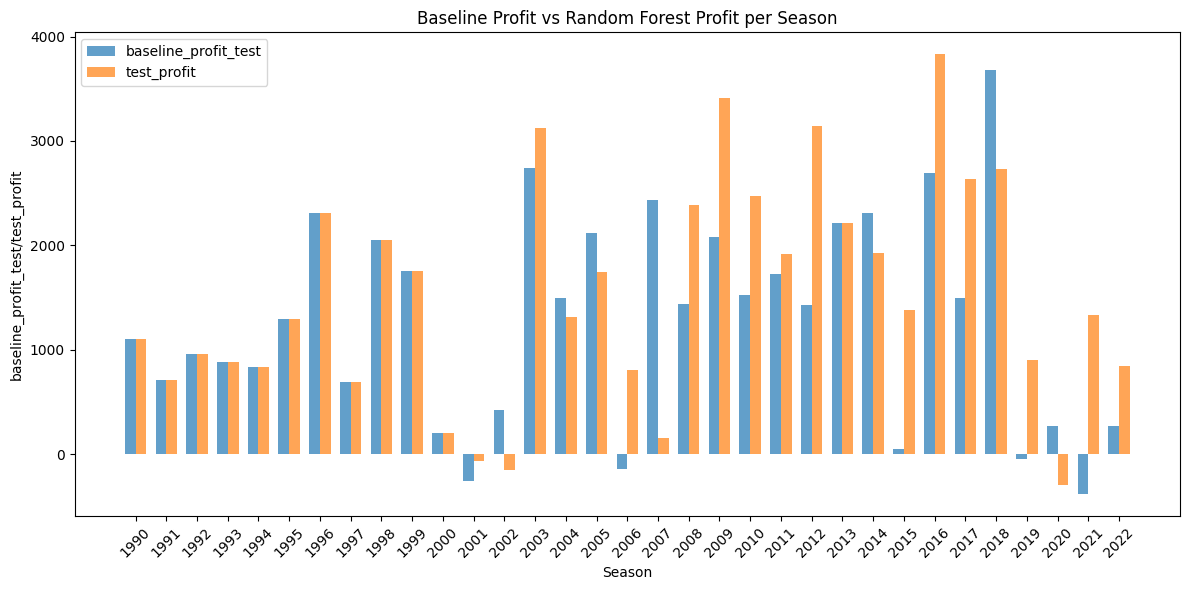

In [ ]:
plot_strategy_comparison(backtest_seasons_rf,baseline,strategic, 'Baseline Profit vs Random Forest Profit per Season')

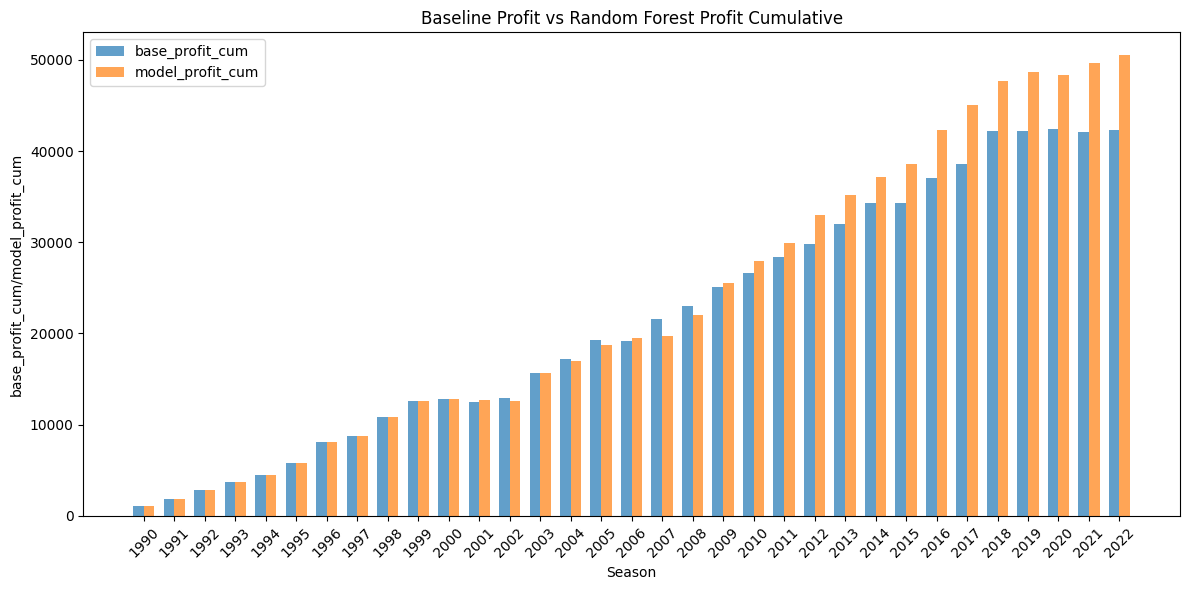

In [ ]:
plot_strategy_comparison(backtest_seasons_rf,baseline_cum,strategic_cum, 'Baseline Profit vs Random Forest Profit Cumulative')

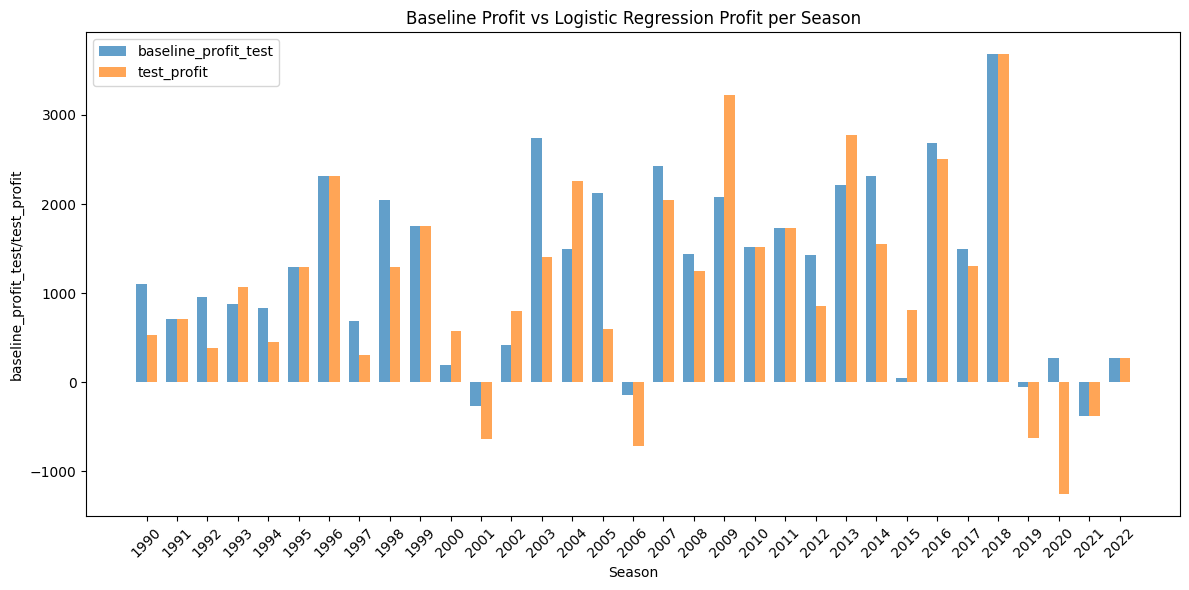

In [ ]:
plot_strategy_comparison(backtest_seasons_logit,baseline,strategic, 'Baseline Profit vs Logistic Regression Profit per Season')

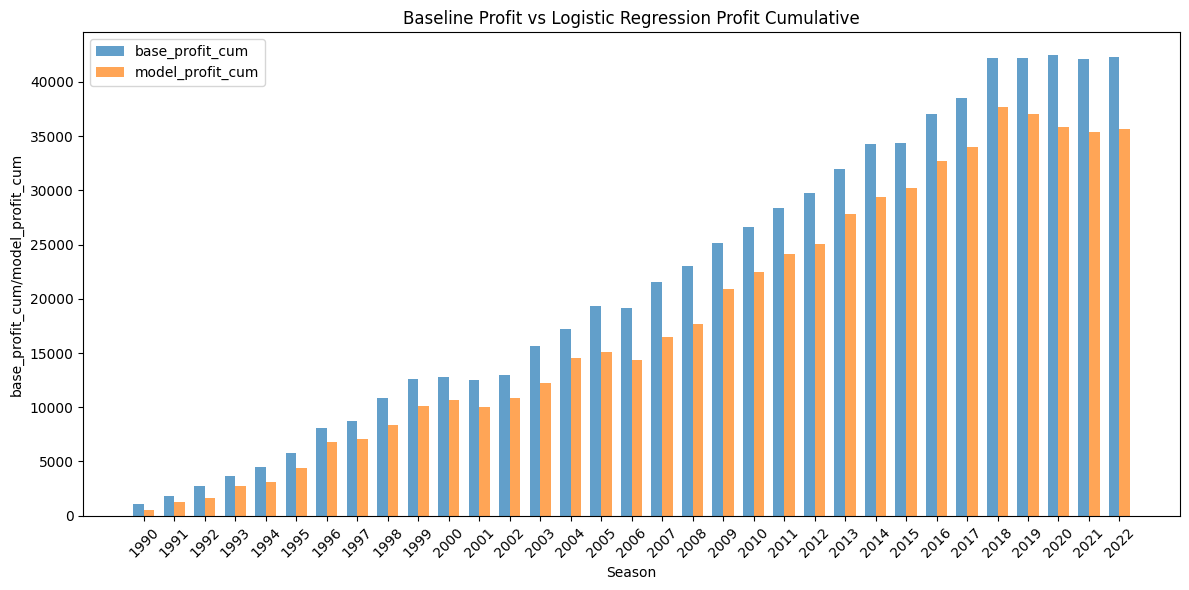

In [ ]:
plot_strategy_comparison(backtest_seasons_logit,baseline_cum,strategic_cum, 'Baseline Profit vs Logistic Regression Profit Cumulative')

In [ ]:
print(backtest_seasons_rf['baseline_profit_test'].mean())
print(backtest_seasons_rf['test_profit'].mean())

1282.7272727272727
1530.3030303030303


In [ ]:
backtest_seasons_logit.columns

Index(['season_choice', 'rows_train', 'rows_test', 'cm_train', 'cm_test',
       'base_accuracy_train', 'base_accuracy_test', 'accuracy_train',
       'accuracy_test', 'baseline_profit_train', 'baseline_profit_test',
       'train_profit', 'test_profit', 'base_profit_cum', 'model_profit_cum'],
      dtype='object')

In [ ]:
# acc yearly cum
baseline_acc = backtest_seasons_rf['base_accuracy_test'].mean()
rf_acc = backtest_seasons_rf['accuracy_test'].mean()
logit_acc = backtest_seasons_logit['accuracy_test'].mean()

print(f'Baseline Accuracy: {baseline_acc:.2f}')
print(f'RF Accuracy: {rf_acc:.2f}')
print(f'Logit Accuracy: {logit_acc:.2f}')

# avg yearly profit

baseline_yearly = backtest_seasons_rf['baseline_profit_test'].mean()
rf_yearly = backtest_seasons_rf['test_profit'].mean()
logit_yearly = backtest_seasons_logit['test_profit'].mean()

print()
print(f'Baseline average yearly profit: {baseline_yearly:.2f}')
print(f'RF average yearly profit: {rf_yearly:.2f}')
print(f'Logit average yearly profit: {logit_yearly:.2f}')

# cumulative profit

baseline_cum = backtest_seasons_rf['base_profit_cum'].iloc[-1]
rf_cum = backtest_seasons_rf['model_profit_cum'].iloc[-1]
logit_cum = backtest_seasons_logit['model_profit_cum'].iloc[-1]

print()
print(f'Baseline cumulative profit: {baseline_cum}')
print(f'RF cumulative profit: {rf_cum}')
print(f'Logit cumulative profit: {logit_cum}')



Baseline Accuracy: 0.60
RF Accuracy: 0.61
Logit Accuracy: 0.58

Baseline average yearly profit: 1282.73
RF average yearly profit: 1530.30
Logit average yearly profit: 1081.21

Baseline cumulative profit: 42330
RF cumulative profit: 50500
Logit cumulative profit: 35680


In [ ]:
# first decision tree
dataviz = df.drop(not_features, axis=1) # drop target variable and others
rf.estimators_[0]

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,10), dpi=800)
plot_tree(rf.estimators_[1], feature_names = dataviz.columns, class_names = ["Home Loss", "Home Win"], filled = True)
fig.savefig('rf_individualtree.png')

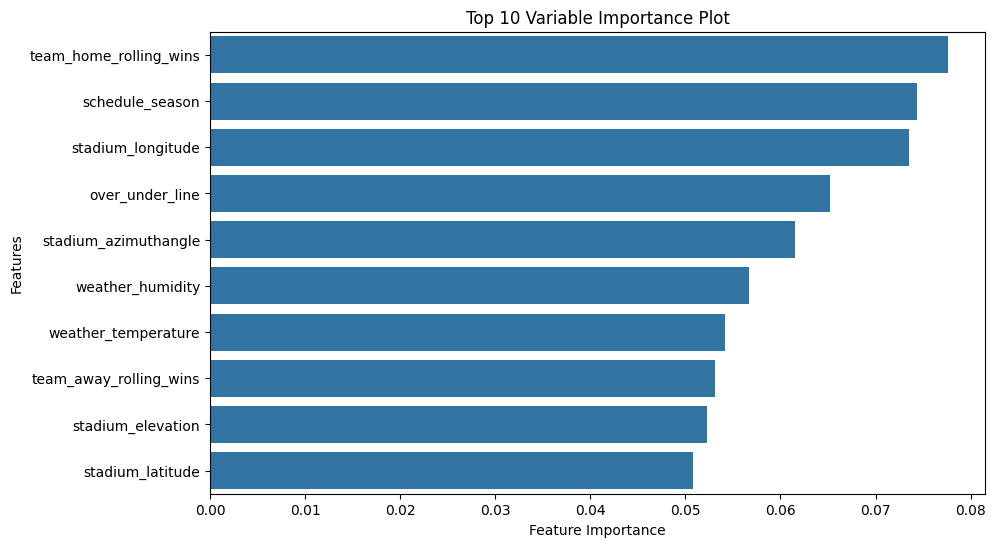

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf.feature_importances_

features = include_columns

top_n = 10  # Number of top features to display

# Sort feature importances in descending order and select top N
indices = np.argsort(importances)[::-1][:top_n]
top_features = [features[i] for i in indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top {} Variable Importance Plot'.format(top_n))
plt.show()